# DNBLab Jupyter Notebook Tutorial

## Digitalisierte Inhaltsverzeichnisse: Datenabfrage, Auslieferung und Volltextanalyse

Dieses DNBLab-Tutorial beschreibt eine Beispielabfrage zu digitalisierten Inhaltsverzeichnissen über die SRU-Schnittstelle und umfasst das temporäre Speichern der Inhaltsverzeichnisse als Textdateien sowie die Analyse der Volltexte nach 

* [1. Häufigkeit eines beliebigen Suchwortes](#Teil1)
* [2. Vorkommen des Suchwortes in den einzelnen Textdateien](#Teil2)
* [3. Top 20 häufigste Wörter in den Textdateien](#Teil3)


## Einrichten der Arbeitsumgebung

Um die Arbeitsumgebung für die folgenden Schritte passend einzurichten, sollten zunächst die benötigten Python-Bibliotheken importiert werden. Für Anfragen über die SRU-Schnittstelle wird Requests (https://docs.python-requests.org/en/latest/) verwendet, zur Verarbeitung der XML-Daten BeautifulSoup https://www.crummy.com/software/BeautifulSoup/ und etree https://docs.python.org/3/library/xml.etree.elementtree.html. Mit Pandas https://pandas.pydata.org/ werden die  aus dem MARC21-Format ausgelesenen Elemente weiterverarbeitet. In der Jupyter Notebook Umgebung kann der dokumentierte Code direkt ausgeführt und angepasst werden.

In [1]:
import requests
from bs4 import BeautifulSoup as soup
import unicodedata
from lxml import etree
import pandas as pd
from collections import Counter

## SRU-Abfrage mit Ausgabe in MARC21-xml

Die Funktion dnb_sru nimmt den Paramter "query" der SRU-Abfrage entgegen und liefert alle Ergebnisse als eine Liste von Records aus. Weitere Informationen und Funktionen der SRU- Schnittstelle werden unter https://www.dnb.de/sru beschrieben.

In [2]:
def dnb_sru(query):
    
    base_url = "https://services.dnb.de/sru/dnb"
    params = {'recordSchema' : 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'maximumRecords': '100',
          'query': query
         }
    r = requests.get(base_url, params=params)
    xml = soup(r.content, features="xml")
    records = xml.find_all('record', {'type':'Bibliographic'})
    
    if len(records) < 100:
        
        return records
    
    else:
        
        num_results = 100
        i = 101
        while num_results == 100:
            
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content)
            new_records = xml.find_all('record', {'type':'Bibliographic'})
            records+=new_records
            i+=100
            num_results = len(new_records)
            
        return records

## Durchsuchen eines MARC-Feldes

Die Funktion parse_records nimmt als Parameter jeweils einen Record entgegen, sucht über xpath die gewünschten Informationen heraus und liefert diese als Dictionary zurück. Die Schlüssel-Werte-Paare können beliebig agepasst und erweitert werden. In diesem Fall werden nur die Permalinks zu den digitalisierten Inhaltsverzeichnissen als "link" ausgegeben.

In [3]:
def parse_record(record):
    
    ns = {"marc":"http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))
    
    
    descriptions = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = '3']", namespaces=ns)
    links = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']", namespaces=ns)
    
    try:
        description1 = descriptions[0].text
    except:
        description1 = "unknown"
        
    try: 
        description2 = descriptions[1].text
    except:
        description2 = "unknown"
        
        
    if description1 == "Inhaltsverzeichnis": 
        link = links[0].text
    elif description2 == "Inhaltsverzeichnis": 
        link = links[1].text
    else:
        link = "unknown"

    
        
        
    meta_dict = {"link":link + '/text'}
    
    return meta_dict

Über verschiedene Indices https://services.dnb.de/sru/dnb?operation=explain&version=1.1 kann die SRU-Abfrage "dnb_sru" mittels CQL https://www.dnb.de/DE/Service/Hilfe/Katalog/kataloghilfeExpertensuche.html eingeschränkt werden. Im Folgenden Code wird die Abfrage über das Stichwort "Sandwespe" im Volltextindex der digitalisierten Inhaltsverzeichnisse eingeschränkt. Durch Anpassen der SRU-Abfrage kann die Trefferliste beliebig geändert werden.

In [4]:
records = dnb_sru('inh=111 Dinge')
print(len(records), 'Ergebnisse')

21 Ergebnisse


## Beispielanzeige zur weiteren Bearbeitung

Mit der Bibliothek Pandas für Python wird das Ergebnis (Dictionary-Element "link") als Dataframe ausgegeben.

In [5]:
output = [parse_record(record) for record in records]
df = pd.DataFrame(output)
df

#Die Ausgabe der ermittelten Links kann je nach Bedarf über verschiedene Funktionen erfolgen:
#print(df.to_string(index=False))
#HTML(df.to_html(index=False))
#document = df.to_dict(orient='list')
#print(document)

,link
0,https://d-nb.info/1231002506/04/text
1,https://d-nb.info/1231000813/04/text
2,https://d-nb.info/1231000651/04/text
3,https://d-nb.info/1207560782/04/text
4,https://d-nb.info/1200950275/04/text
5,https://d-nb.info/1218613459/04/text
6,https://d-nb.info/1209563045/04/text
7,https://d-nb.info/1183712243/04/text
8,https://d-nb.info/1179561996/04/text
9,https://d-nb.info/1148135065/04/text


## Download der Textdateien 

Mit der folgenden Funktion df.to_csv() werden die Ergebnisse als "links.csv" in das Jupyter-Verzeichnins der Einstiegsseite abgelegt und können dort heruntergeladen werden. 

In [6]:
df.to_csv("links.csv", index=False)

Mit wget werden alle in der CSV-Datei gespeicherten Links heruntergeladen und als Textdateien (text, text.1, text.2, usw.) im temporären Jupyter-Verzeichnis gespeichert (Downloadlimit 1MB). 

In [7]:
!wget -Q1m -i links.csv

--2022-08-02 10:39:28--  http://link/
Resolving link (link)... failed: No address associated with hostname.
wget: unable to resolve host address ‘link’
--2022-08-02 10:39:28--  https://d-nb.info/1231002506/04/text
Resolving d-nb.info (d-nb.info)... 193.175.100.223
Connecting to d-nb.info (d-nb.info)|193.175.100.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7322 (7.2K) [text/plain]
Saving to: ‘text’

text                100%[===================>]   7.15K  --.-KB/s    in 0s      

2022-08-02 10:39:28 (482 MB/s) - ‘text’ saved [7322/7322]

--2022-08-02 10:39:28--  https://d-nb.info/1231000813/04/text
Reusing existing connection to d-nb.info:443.
HTTP request sent, awaiting response... 200 OK
Length: 8132 (7.9K) [text/plain]
Saving to: ‘text.1’

text.1              100%[===================>]   7.94K  --.-KB/s    in 0s      

2022-08-02 10:39:28 (77.7 MB/s) - ‘text.1’ saved [8132/8132]

--2022-08-02 10:39:28--  https://d-nb.info/1231000651/04/text
Reusing exi

## Volltextanalyse 

### 1. Häufigkeit eines beliebigen Suchwortes<a class="anchor" id="Teil1"></a>

Die heruntergeladenen Textdateien können nach einem Suchwort, z.B. search = "biene" durchsucht werden. Als Antwort werden die durchsuchten Textdateien genannt und die Häufigkeit des gesuchten Wortes in den genannten Dateien ausgegeben. Dabei entspricht die Dateibenennung den im Verzeichnis heruntergeladen Textdateien (text, text1, text2 usw.).
Das Suchwort kann beliebig geändert und die Suche durch Ausführen des Codes angepasst werden.

In [8]:
# Eingabe des Suchwortes mit Button zur Übernahme der eingegebenen Werte 

from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout 

tb1 = widgets.Text(value = 'biene', description ='Suchwort: ');display(tb1);


button = widgets.Button(description='Übernehmen!', layout=Layout(width='200px')); 
button.style.button_color='lightgreen';display(button); 
def on_button_clicked(sender): 
    a = tb1.value; 
    print('Folgendes Suchwort wurde übernommen: ' + str(tb1.value))     
button.on_click(on_button_clicked)

Text(value='biene', description='Suchwort: ')

Button(description='Übernehmen!', layout=Layout(width='200px'), style=ButtonStyle(button_color='lightgreen'))

Nach Übernahme des Suchworts werden alle Treffer in den Dateien gezählt und ausgegeben.

In [18]:
# Automatische Verarbeitung der Dateinamen

def adding_name(counter):

    i = 1
    names = []

    for i in range (1, counter): 
        number = str(i)
        name = "text." + number
        names.append(name)
        i+=1
    
    return names 
    


counter = len(records)

var = adding_name(counter)
print("Folgende Textdateien wurden durchsucht: \n text", *var, sep = "\n") 


# Suche und Zählen der Zeilen mit Treffern

search = str(tb1.value).lower()
anzahl = 0 
anzahl2 = 0

filename = 'text'
with open(filename, encoding="utf-8", errors="ignore") as f:
    items = f.readlines()
    for line in items:
        line = line.lower()
        if search in line:
            anzahl += 1
            
for name in var: 
    with open(name, encoding="utf-8", errors="ignore") as f:
        for num, line in enumerate(f, 1):
            line = line.lower() #Umwandeln in Kleinbuchstaben
            if search in line:
                anzahl2 += 1

print('Insgesamt wurde das Suchwort', anzahl+anzahl2, "Mal in den zu durchsuchenden Textdateien gefunden.")

Folgende Textdateien wurden durchsucht: 
 text
text.1
text.2
text.3
text.4
text.5
text.6
text.7
text.8
text.9
text.10
text.11
text.12
text.13
text.14
text.15
text.16
text.17
text.18
text.19
text.20
Insgesamt wurde das Suchwort 8 Mal in den zu durchsuchenden Textdateien gefunden.


### 2. Vorkommen des Suchwortes in den einzelnen Textdateien<a class="anchor" id="Teil2"></a>

Alle Treffer werden mit Angabe der Zeile und Datei ausgegeben. 


In [19]:
search = str(tb1.value).lower() 
new_file = open('Trefferliste.txt', 'w')

filename = 'text'
with open(filename, encoding="utf-8", errors="ignore") as f:
    for num, line in enumerate(f, 1):
        line = line.lower() #Umwandeln in Kleinbuchstaben
        if search in line:
            print('Das Suchwort "%s" wurde gefunden in Zeile:' % search, num , 'in der Datei ',filename)
            text = ('Das Suchwort "%s" wurde gefunden in Zeile:' % search, num , 'in der Datei ',filename)
            new_file.write(str(text) + "\n")
            #summary.append(text)
            
            
#Einbau der Schleife erst hier wegen des leicht anderen Formats der Dateinamen... :             
for name in var: 
    with open(name, encoding="utf-8", errors="ignore") as f:
        for num, line in enumerate(f, 1):
            line = line.lower() #Umwandeln in Kleinbuchstaben
            if search in line:
                print('Das Suchwort "%s" wurde gefunden in Zeile:' % search, num , 'in der Datei ',name) 
                text2 = ('Das Suchwort "%s" wurde gefunden in Zeile:' % search, num , 'in der Datei ',name)
                new_file.write(str(text2) + "\n")
                
new_file.close()

with open('Trefferliste.txt') as f:
    #lines = f.readlines()
    result = f.read()

Das Suchwort "größe" wurde gefunden in Zeile: 212 in der Datei  text
Das Suchwort "größe" wurde gefunden in Zeile: 142 in der Datei  text.9
Das Suchwort "größe" wurde gefunden in Zeile: 10 in der Datei  text.14
Das Suchwort "größe" wurde gefunden in Zeile: 12 in der Datei  text.14
Das Suchwort "größe" wurde gefunden in Zeile: 111 in der Datei  text.14
Das Suchwort "größe" wurde gefunden in Zeile: 208 in der Datei  text.14
Das Suchwort "größe" wurde gefunden in Zeile: 364 in der Datei  text.18
Das Suchwort "größe" wurde gefunden in Zeile: 524 in der Datei  text.19


### 3. Top 20 häufigste Wörter in den Textdateien<a class="anchor" id="Teil3"></a>
Das Vorkommen der Wörter in den Textdateien wird ausgenommen vordefinierter Stopwörter gezählt und die 20 häufigsten Wörter inklusive Treffermenge ausgegeben.

In [20]:
content = []

filename = 'text'
with open(filename, encoding="utf-8", errors="ignore") as f:
    file1 = f.read()
    content.append(file1.lower())
            
#Einbau der Schleife erst hier wegen des leicht anderen Formats der Dateinamen... :             
for name in var: 
    with open(name, encoding="utf-8", errors="ignore") as f:
        morefiles = f.read()
        content.append(morefiles.lower())
        
import string

listofthings = list()

for entry in content:      
    #Remove punctuation
    for c in string.punctuation:
        entry= entry.replace(c," ")
    test = str.split(entry)
    listofthings.extend(test)
    
#Enternen der Seitenzahlen:
words = []
        
for item in listofthings: 
    if item.isdecimal() is True: 
        continue
    else: 
        words.append(item)
        
counts = Counter(words)

#Importieren der zu entfernenden Stopwörter (wie bpsw. "und", "der", etc.):

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

stopger = stopwords.words('german')

newStopwords = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
              'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'vgl', '\x97', '•', '■', 'v',
               'beim', 'inhaltsverzeichnis', 'seite']

stopger.extend(newStopwords)

tokens_without_sw = [word for word in words if not word in stopger]
counts = Counter(tokens_without_sw)



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Die Ausgabe der "Top-Zahl" kann beliebig angepasst werden

In [21]:
# Ändern der Zahl Top 20:
print(counts.most_common(20))

[('übersetzt', 232), ('win32', 79), ('ed', 64), ('dinge', 45), ('elefanten', 45), ('kapitel', 41), ('win', 38), ('leben', 35), ('schule', 32), ('—', 30), ('tennis', 30), ('mehr', 29), ('wer', 29), ('us', 28), ('gibt', 26), ('schwein', 26), ('modi', 26), ('lied', 26), ('john', 25), ('immer', 24)]


Die häufigsten Wörter werden in einer Tabelle zur weiteren Bearbeitung angezeigt.

In [22]:
df = pd.DataFrame(counts.most_common(20), columns=['Wort', 'Häufigkeit'])
df

,Wort,Häufigkeit
0,übersetzt,232
1,win32,79
2,ed,64
3,dinge,45
4,elefanten,45
5,kapitel,41
6,win,38
7,leben,35
8,schule,32
9,—,30


Die häufigsten Wörter werden in einem Diagramm ausgegeben.

<AxesSubplot:title={'center':'Worthäufigkeiten'}, xlabel='Wort'>

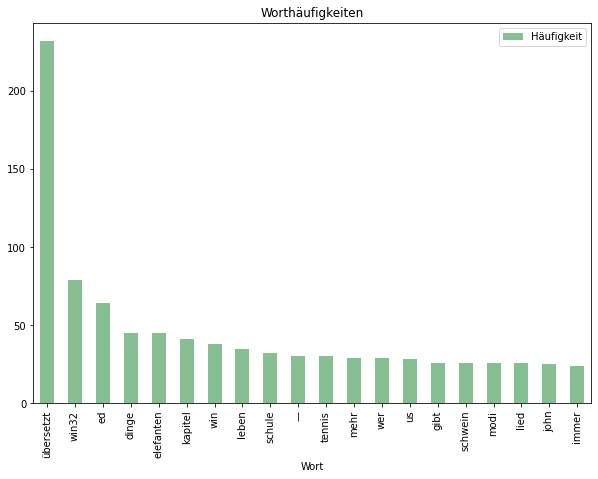

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

df.plot(kind='bar', x=0, y=1, title='Worthäufigkeiten', figsize=(10,7), color='#86bf91')